In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from sklearn.metrics import pairwise_distances
from shapely.geometry import LineString


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

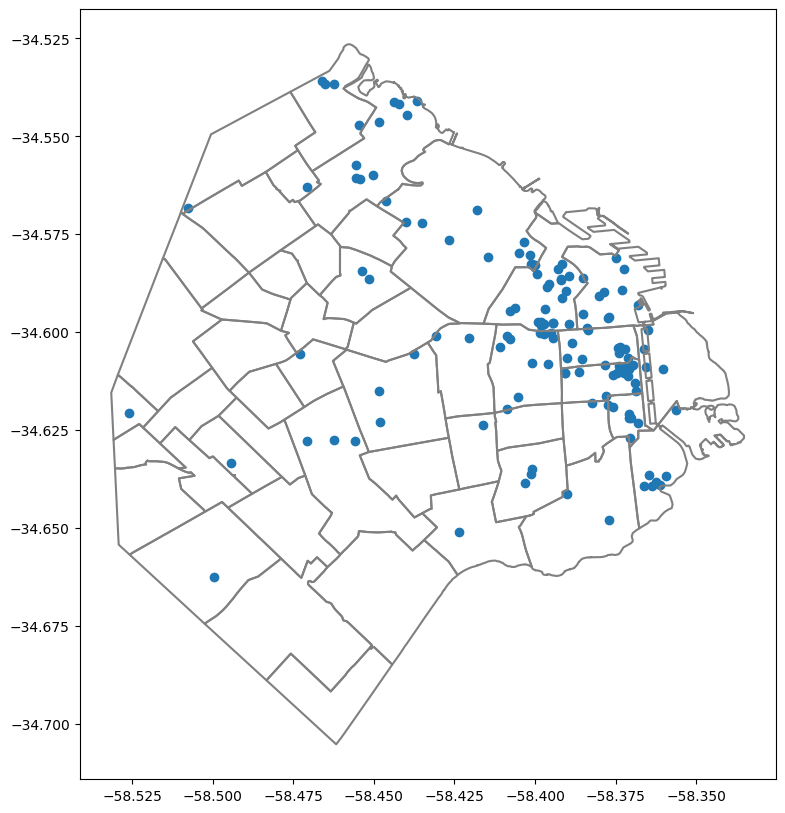

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):    #LISTO
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

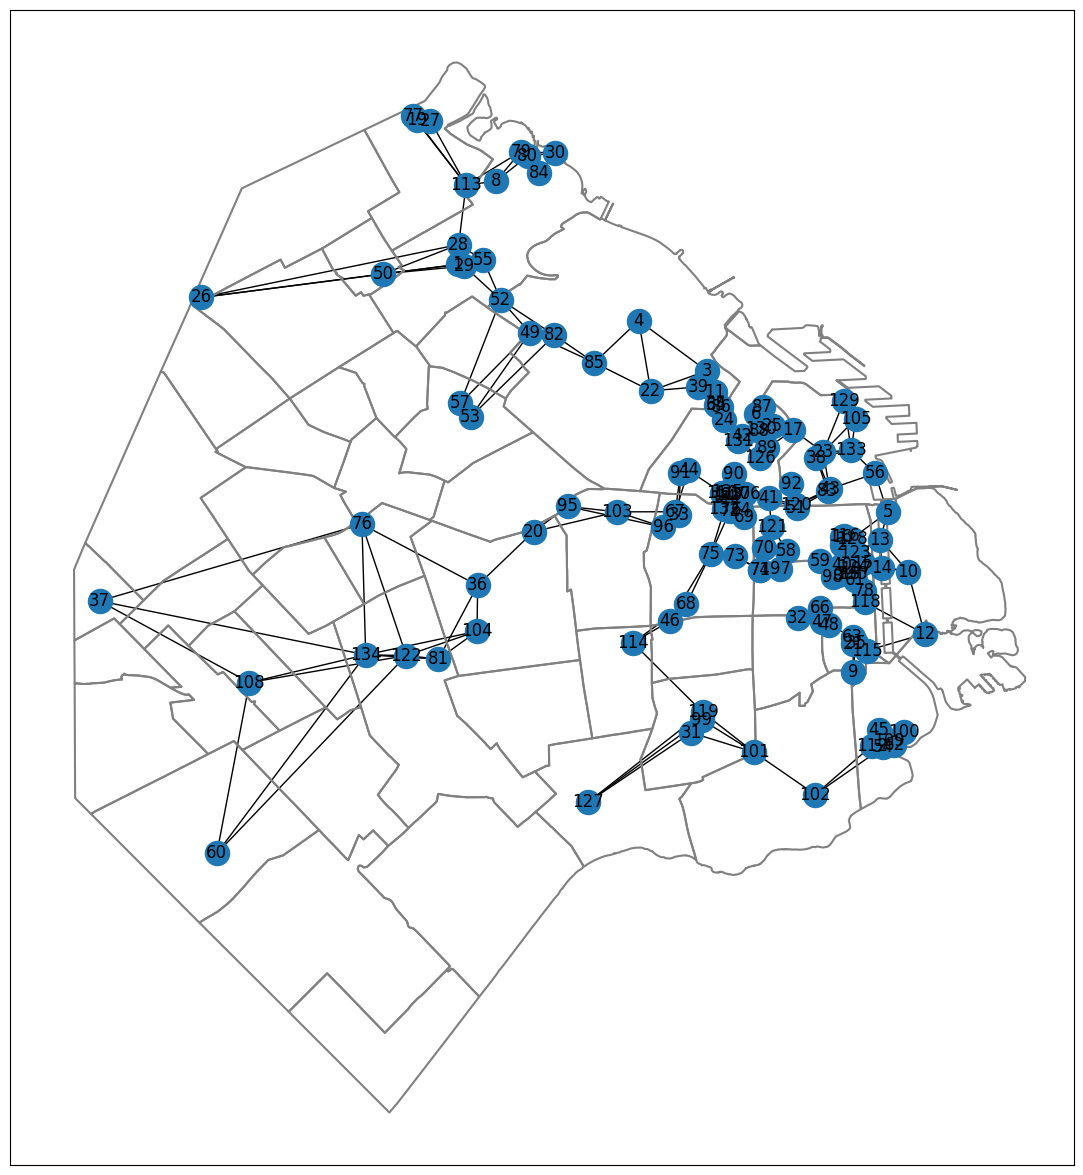

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

In [8]:
#FUNCIONES NECESARIAS PARA CORRER BIEN EL CODIGO
def calculaLU(matriz): 
    N = matriz.shape[0]
    L = np.zeros_like(matriz, dtype=float)
    U = np.zeros_like(matriz, dtype=float) 
    # eliminacion de Gauss
    for i in range(N):
        # armo L
        for j in range(i, N):
            U[i, j] = matriz[i, j] - np.dot(L[i, :i], U[:i, j])
        
        for j in range(i+1, N):
            L[j, i] = (matriz[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]
    np.fill_diagonal(L, 1)
    return L, U
def calcula_matriz_C(A): 
    # matriz de grados K
    K = np.sum(A, axis=1)
    # inversa de k
    K_inv = np.diag(1 / K)  
     # transpuesta 
    A_T = A.T  
    C = np.dot(A_T, K_inv)  
    return C  
def calcula_pagerank(A, alfa): 
    
    C = calcula_matriz_C(A)
    N = A.shape[0]
    I = np.eye(N)
    M = N / alfa * (I - (1 - alfa) * C)
    L, U = calculaLU(M)
    b = np.ones(N)
    y = scipy.linalg.solve_triangular(L, b, lower=True)
    p = scipy.linalg.solve_triangular(U, y)

    return p

## Punto 1:

En este ejercicio se parte de la ecuación original de PageRank, pensada inicialmente para navegar la web, pero ahora aplicada al contexto de La Noche de los Museos en la Ciudad Autónoma de Buenos Aires. En este evento, los visitantes se desplazan de un museo a otro a lo largo de una noche, y se modela este comportamiento como una caminata aleatoria sobre una red de museos conectados. 

Cada museo está representado como un nodo en la red, y las conexiones entre ellos indican las posibles transiciones de un visitante desde un museo hacia otro. Esta dinámica se representa mediante una matriz de transición, denotada como $C$, en la que la entrada $C_{ji}$ indica la probabilidad de que un visitante que está en el museo $i$ se dirija al museo $j$. 

En este contexto, la ecuación de PageRank que se utiliza es la siguiente:

$$
p = (1 - \alpha) C p + \frac{\alpha}{N} \cdot \mathbf{1}
$$

Donde $p$ es el vector de relevancia de dimensión $N$ (cantidad de museos), $\alpha$ es un parámetro entre 0 y 1 que representa la probabilidad de que el visitante decida reiniciar su recorrido desde un museo elegido al azar en lugar de seguir transitando la red, $N$ es la cantidad total de museos y $\mathbf{1}$ es un vector columna con todos sus elementos iguales a uno.

El objetivo es reescribir esta ecuación en forma matricial para poder resolverla utilizando métodos numéricos de la siguiente manera:

Se trasladan todos los términos con $p$ al mismo lado de la ecuación, resultando en: 

$$
p - (1 - \alpha) C p = \frac{\alpha}{N} \cdot \mathbf{1}
$$

A partir de aquí, se puede factorizar $p$ del lado izquierdo de la ecuación, donde $I$ es la matriz identidad de tamaño $N \times N$, así obteniendo:

$$
(I - (1 - \alpha) C) p = \frac{\alpha}{N} \cdot \mathbf{1}
$$

Esta forma ya representa un sistema lineal de la forma $M p = b$, pero para que el término del segundo miembro sea más sencillo, se puede multiplicar ambos lados de la ecuación por el escalar $\frac{N}{\alpha}$, de manera que el segundo miembro se transforme directamente en el vector $\mathbf{1}$. 

Ahora se puede definir $M$ como: $\frac{N}{\alpha}(I - (1 - \alpha) C)$ y $b$ como el vector $\mathbf{1}$. 
Esto da como resultado la ecuación:

$$
\frac{N}{\alpha}(I - (1 - \alpha) C) p = \mathbf{1}
$$

Por lo tanto, se obtiene el sistema $M p = b$, el cual se podrá resolver luego para obtener el vector de rankings $p$.

Este sistema lineal tiene la ventaja de ser tratable numéricamente, y se podrá abordar más adelante mediante *factorización LU*, un método eficiente y numéricamente estable para resolver ecuaciones lineales sin necesidad de invertir matrices explícitamente.


Desde el punto de vista de la implementación en Python, se puede construir una función que reciba la matriz de transición C y el parámetro alpha, y devuelva tanto la matriz M como el vector b: 

```python
def construir_M_y_b(C, alpha):
    N = C.shape[0]  # Guarda N, la cantidad de filas/columnas de la matriz C
    I = np.eye(N)   # Construye la matriz identidad de tamaño NxN
    M = (N / alpha) * (I - (1 - alpha) * C)
    b = np.ones(N)  # Construye el vector columna b de unos
    return M, b
```

Con esto queda finalizado el desarrollo del ejercicio 1, en el que se logró reescribir la ecuación de PageRank como un sistema lineal listo para resolverse numéricamente, lo cual será fundamental para poder calcular el ranking de los museos en base a su ubicación y la probabilidad de ser visitados a lo largo del evento.

## Punto 2:


 
La existencia y unicidad de la solución del sistema $Mp=b$ depende de si la matriz M es inversible. Un sistema lineal como este tiene una única solución si y solo si la matriz que acompaña al vector incógnita (en este caso p) es inversible.  
Una matriz es inversible cuando sus filas (o columnas) son linealmente independientes, es decir, no se pueden obtener unas a partir de otras mediante combinaciones lineales, su determinante es distinto de 0 o equivalentemente, que el núcleo de M es trivial (solo contiene al vector nulo). Veamos entonces por qué, en este contexto particular, la matriz M es efectivamente invertible. Para ello, veamos cómo está construida dicha matriz:  

$$
M = \frac{N}{\alpha}(I - (1 - \alpha) C)
$$

Donde $I$ es la matriz identidad de tamaño $N \times N$, $C$ es la matriz de transición que describe la probabilidad de moverse de un museo a otro, $\alpha \in (0,1)$ es el parámetro de amortiguamiento que regula la probabilidad de reiniciar la caminata en un museo aleatorio y $\mathbf{1}$ es el vector columna con todos sus elementos iguales a 1.

Para empezar, recordemos que la matriz $C$ es una matriz de transición construida a partir de la red de museos. Esta red se forma considerando las distancias entre los museos y aplicando una función que da más peso a las conexiones entre museos cercanos.

Esto da como resultado una matriz de transición $C$, *estocástica por columnas* (Matriz de Markov), donde cada columna representa una distribución de probabilidad (es decir, cada columna suma 1).

La matriz $M$ incorpora además el parámetro $\alpha$, que representa la probabilidad de cortar una caminata aleatoria en un momento dado y empezar desde un nuevo museo elegido al azar. Este parámetro introduce lo que se llama una *reinicialización aleatoria* en la caminata. En términos prácticos, garantiza que siempre hay una posibilidad de visitar cualquier museo, incluso si no está conectado directamente a otros.

Entonces veamos si realmente $M$ es inversible. Primero definamos:

$$
A = I - (1 - \alpha)C
$$

Queremos ver si $A$ es inversible. Supongamos que no, entonces existe un vector $x \neq 0$ tal que $Ax = 0$, es decir:

$$
(I - (1 - \alpha)C)x = 0 \Rightarrow Cx = \frac{1}{1 - \alpha}x
$$

Esto implica que $x$ es autovector de $C$ con autovalor $\lambda = \frac{1}{1 - \alpha}$. Pero como $C$ es una matriz de Markov, se sabe que todos sus autovalores $\lambda$ verifican $|\lambda| \leq 1$. Entonces:

$$
\left| \frac{1}{1 - \alpha} \right| > 1 \quad \text{(ya que } 0 < \alpha < 1) \Rightarrow \text{contradicción (absurdo)}
$$

Llegamos a un absurdo, por lo tanto no puede existir tal vector $x$, lo que implica que $A$ es invertible, y por lo tanto $M$ también lo es.

Finalmente, el sistema lineal $Mp = b$ tiene una única solución. Esta solución representa el *ranking de los museos*, es decir, la distribución de probabilidad que indica qué tan probable es que un caminante aleatorio se encuentre en cada museo luego de recorrer la red durante un largo período de tiempo.



## Punto 3

### 3a)

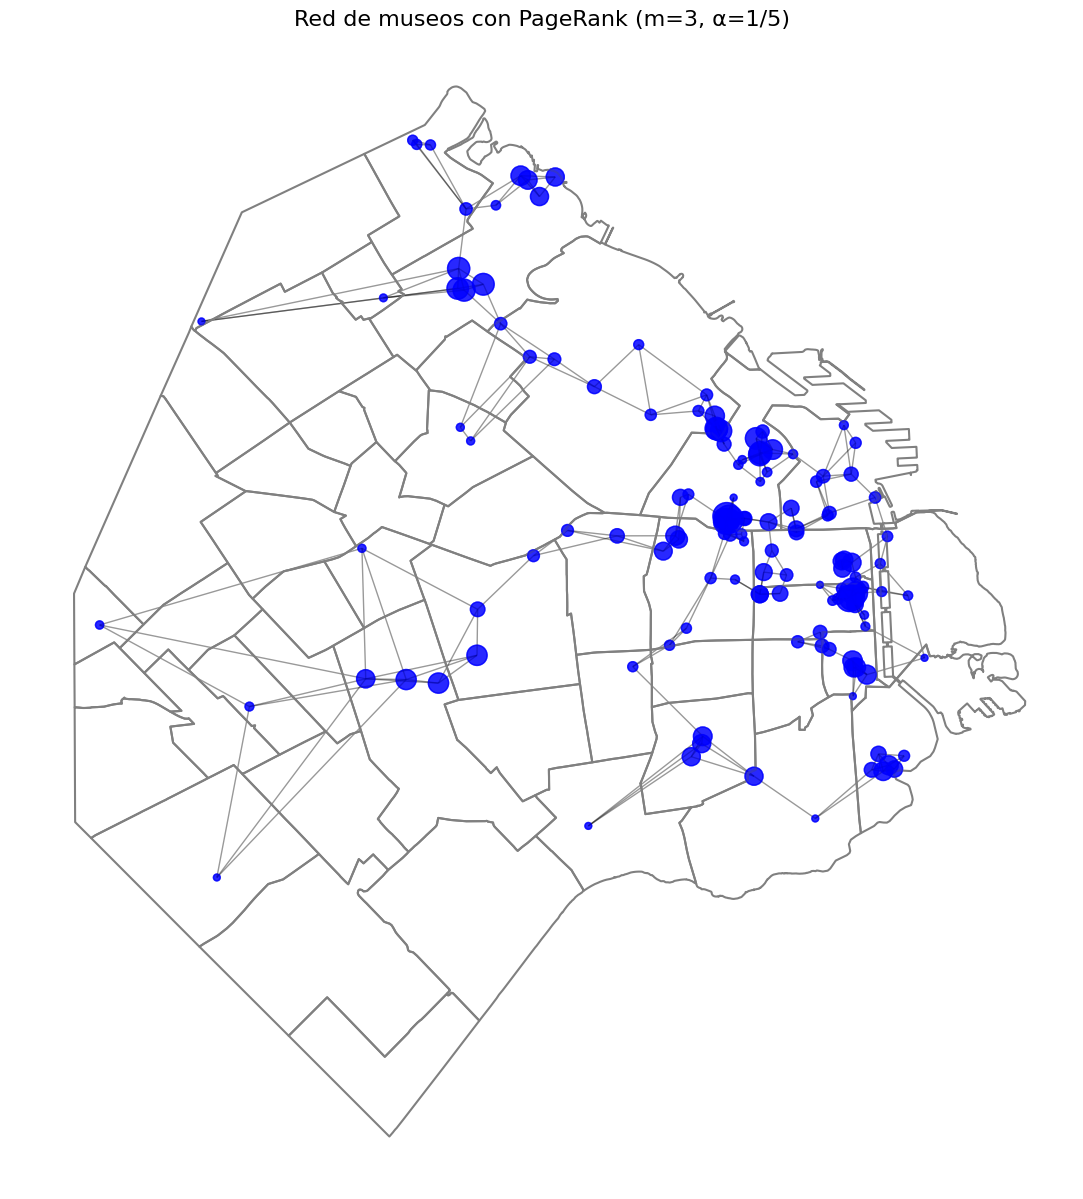

In [9]:
#> Estas cosas ya estaban hechas arriba de todo en el notebook. Esas cosas se mantienen entre celdas, no tienen que volver a hacerlas ustedes.

#3a
m = 3
alfa = 1/5

# Matriz de adyacencia y PageRank
A = construye_adyacencia(D, m)
p = calcula_pagerank(A, alfa)
p_normalizado = p / np.max(p)
museos['pagerank'] = p
museos['pagerank_norm'] = p_normalizado

# Creo un grafico con la matriz A
G = nx.from_numpy_array(A)

museos_proj = museos.to_crs("EPSG:22184")
coords = museos_proj.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
G_layout = {i: coord for i, coord in enumerate(coords)}

#Grafico 
fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
museos_proj.plot(ax=ax, markersize=museos['pagerank_norm'] * 400, alpha=0.6, color='blue')
nx.draw_networkx_edges(G, G_layout, ax=ax, alpha=0.4)
nx.draw_networkx_nodes(G, G_layout, ax=ax, node_size=museos['pagerank_norm'] * 400, node_color='blue', alpha=0.6)
plt.title("Red de museos con PageRank (m=3, α=1/5)", fontsize=16)
plt.axis('off')
plt.show()

### 3b)

Analizamos distintas configuraciones de red variando la cantidad de vecinos ($m = 1, 3, 5, 10$), manteniendo fijo el valor de $\alpha = \frac{1}{5}$. Para cada valor de $m$, se calculó el vector de PageRank utilizando el siguiente código:

In [10]:
#3b
m_vals = [1, 3, 5, 10]
resultados_m = {}

for m in m_vals:
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    resultados_m[m] = p

df_m = pd.DataFrame(resultados_m)
df_m.insert(0, 'name', museos['name'].values)
df_m

,name,1,3,5,10
0,Manzana de las Luces,0.013235,0.003563,0.008543,0.016971
1,Museo de Arte Español 'Enrique Larreta',0.021209,0.014411,0.009024,0.010336
2,Museo del Banco Central,0.001471,0.009228,0.005459,0.008135
3,Museo de Arte Latinoamericano de Buenos Aires,0.001471,0.004306,0.005636,0.004810
4,Museo de artes plásticas 'Eduardo Sívori',0.001471,0.003077,0.003125,0.003185
...,...,...,...,...,...
131,Museo de Ciencia y Técnica,0.007353,0.002638,0.005416,0.011894
132,Museo de la Deuda Externa,0.007353,0.004538,0.006702,0.015458
133,Museo Iser,0.002647,0.006123,0.004869,0.003639
134,Museo Histórico Vecinal de Flores,0.005706,0.010396,0.007623,0.003671


Cada iteración construye la matriz de adyacencia correspondiente y calcula el ranking de los museos, almacenándolo para su comparación.

Con los gráficos resultantes de este ejercicio, interpretamos que a medida que $m$ aumenta, la red se vuelve más densa y los rankings se estabilizan. Con valores bajos de $m$, algunos museos destacan localmente, pero al aumentar las conexiones, los más centrales a nivel global tienden a ocupar los primeros puestos del ranking. Esto permite observar qué museos son consistentemente relevantes y cuáles dependen de una red más dispersa para ganar centralidad.

### 3c)

Para analizar cómo varía el PageRank en función del parámetro $\alpha$, fijamos el número de conexiones por museo en $m = 5$ y probamos distintos valores de $\alpha$. Utilizamos el siguiente código:

In [11]:
#3c
m = 5
alfa_vals = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
resultados_alfa = {}

A = construye_adyacencia(D, m)

for alfa in alfa_vals:
    p = calcula_pagerank(A, alfa)
    resultados_alfa[alfa] = p

Este fragmento genera una matriz de adyacencia fija con $m = 5$ y luego calcula el vector de PageRank para distintos valores del parámetro $\alpha$, que regula la probabilidad de reiniciar aleatoriamente la caminata desde un museo al azar.  

Al analizar los resultados obtenidos con distintos valores de $\alpha$, notamos que a medida que este parámetro disminuye, los museos que se encuentran en el centro de la red tienden a adquirir más relevancia en comparación con aquellos en la periferia. Esto tiene sentido, ya que con un $\alpha$ pequeño, el modelo de PageRank se ve más influenciado por la estructura de la red y las transiciones entre museos cercanos. A su vez, el efecto de $\alpha$ sobre los museos más periféricos varía según el número de conexiones, lo que subraya la importancia de ajustar este parámetro para controlar el balance entre la exploración aleatoria y la caminata estructural.  
Cuando $\alpha$ está cerca de 1, el modelo de PageRank realiza casi siempre un salto aleatorio a un museo al azar y apenas sigue los enlaces.  

En este caso, la importancia que recibe cada museo depende mucho de cómo está conectada la red. Los museos que están en el centro de la red o tienen muchas conexiones suelen recibir un valor de PageRank más alto, ya que es más probable que una caminata aleatoria llegue hasta ellos y se mantenga cerca. En cambio, los museos más alejados o con pocas conexiones reciben menos importancia, porque es difícil llegar a ellos sin los saltos aleatorios. Por eso, cuando $\alpha$ se acerca a 1, el ranking se basa casi por completo en la estructura de la red, y la distribución de importancia entre los museos puede volverse más desigual.  

En resumen, el valor de $\alpha$ y la cantidad de conexiones $m$ tienen un impacto directo en la importancia relativa de los museos. Este análisis demuestra cómo pequeñas variaciones en los parámetros pueden cambiar drásticamente el comportamiento del algoritmo y cómo la conectividad de la red afecta la visibilidad de los museos en la red de PageRank.

### Usando los valores de $p$ obtenidos para cada caso:


### 3a)

Variando el valor de m:  
Para analizar cómo varía la centralidad de los museos según la cantidad de conexiones consideradas en la red, utilizamos los valores de PageRank calculados previamente para distintos valores de m. A partir de estos resultados, construimos un DataFrame que agrupa los vectores p correspondientes a cada valor de m. Luego, identificamos los tres museos más centrales y graficamos sus puntajes de PageRank en función de m:

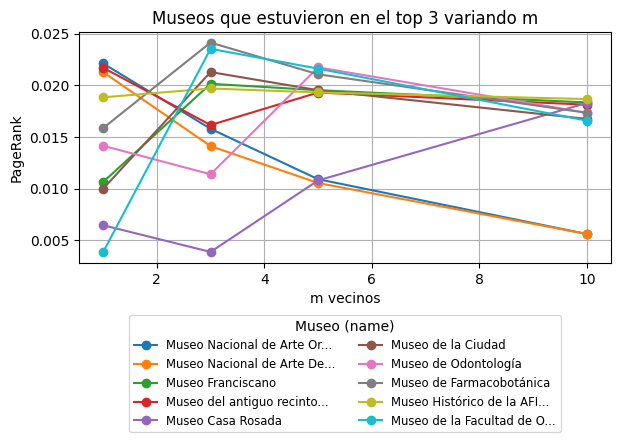

In [12]:
# Creo un dataframe con los resultados del pagerank variando m
df_m = pd.DataFrame(resultados_m)
top_museos = set()
for col in df_m.columns:
    top_3 = df_m[col].nlargest(3).index
    top_museos.update(top_3)
top_museos = list(top_museos)

df_m_top_varios = df_m.loc[top_museos].T
nombres_top_varios = museos.loc[top_museos, 'name'].values
nombres_top_varios = [nombre[:25] + '...' if len(nombre) > 25 else nombre for nombre in museos.loc[top_museos, 'name'].values]

ax = df_m_top_varios.plot(marker='o')
ax.set_title("Museos que estuvieron en el top 3 variando m")
ax.set_xlabel("m vecinos")
ax.set_ylabel("PageRank")
ax.grid(True)
ax.legend(nombres_top_varios, title='Museo (name)', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

Al analizar los resultados, se observa que ciertos museos mantienen posiciones elevadas de PageRank de forma consistente a medida que se incrementa el número de conexiones mmm, lo cual indica que su ubicación en la red es estructuralmente central. Estos museos tienden a estar bien conectados con varios otros, o en zonas donde las distancias a otros nodos son pequeñas.  
Sin embargo, también se identifican museos que solo aparecen entre los más importantes para valores bajos de m pero pierden relevancia cuando la red se vuelve más densa. Esto sugiere que su importancia está relacionada con una posición local favorable, por ejemplo, ser el nodo más cercano en un área poco conectada, pero que esa ventaja desaparece al aumentar las conexiones.  
En cambio, al incrementar m, algunos museos que no eran relevantes en redes más dispersas comienzan a escalar en el ranking. Esto suele deberse a que ganan visibilidad en la red al establecerse más caminos que los conectan con el resto de los museos. Por lo tanto, se puede decir que ciertos museos se vuelven más importantes cuando se consideran estructuras más globales de conectividad.  
En conclusión, las posiciones en el ranking no son completamente estables dependen del valor de m, y con él, de cuán local o global es la estructura de la red. Esto evidencia la sensibilidad del modelo a los parámetros de construcción de la red, y la importancia de interpretarlos en función del objetivo de análisis.  


##### Variando el valor de alpha:  
A partir de los resultados guardados en resultados_alpha, construimos un DataFrame para estudiar cómo varía el PageRank de los museos más relevantes cuando se cambia el parámetro α, que regula la probabilidad de reiniciar la caminata aleatoria. Para esta parte del análisis, se fijó m=5, es decir, cada museo se conecta con sus 5 vecinos más cercanos.

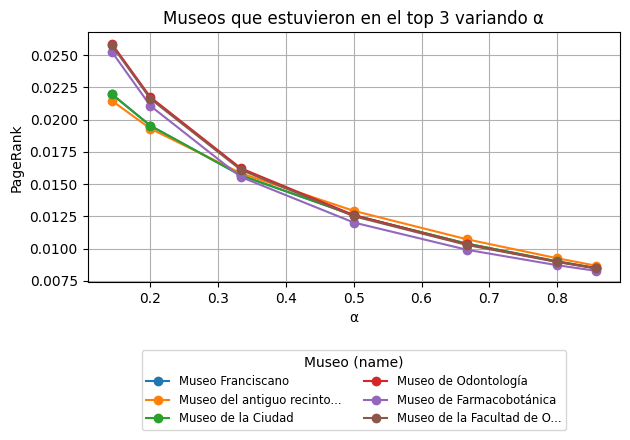

In [13]:
df_alpha = pd.DataFrame(resultados_alfa)

# Encontrar todos los museos que estuvieron en el top 3 para algún valor de alfa
top_museos_alpha = set()
for col in df_alpha.columns:
    top_3 = df_alpha[col].nlargest(3).index
    top_museos_alpha.update(top_3)

top_museos_alpha = list(top_museos_alpha)
df_alpha_top_varios = df_alpha.loc[top_museos_alpha].T
df_alpha_top_varios.index = alfa_vals
df_alpha_top_varios.sort_index(ascending=False, inplace=True)

# Acortar nombres largos para la leyenda
nombres_top_varios_alpha = [
    nombre[:25] + '...' if len(nombre) > 25 else nombre
    for nombre in museos.loc[top_museos_alpha, 'name'].values
]

# Plot
ax = df_alpha_top_varios.plot(marker='o')
ax.set_title("Museos que estuvieron en el top 3 variando α")
ax.set_xlabel("α")
ax.set_ylabel("PageRank")
ax.grid(True)

# Leyenda con múltiples columnas debajo del gráfico
ax.legend(nombres_top_varios_alpha, title='Museo (name)', loc='upper center',
          bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize='small')

plt.tight_layout()
plt.show()

La interpretación del gráfico muestra cómo la importancia relativa de los museos cambia con los distintos valores de α. Recordemos que bajos altos de α favorecen los movimientos locales en la red, mientras que valores altos incrementan la probabilidad de saltar a cualquier nodo aleatoriamente.  

En el gráfico se observa que todos los museos que alguna vez estuvieron en el top 3 presentan un comportamiento similar: su valor de PageRank disminuye a medida que aumenta el parámetro 𝛼. Esto sugiere que estos museos obtienen una mayor relevancia cuando se favorecen cuando 𝛼 es bajo.  
Este comportamiento  uniforme dentro del top 3 indica que, en este caso, los museos más destacados tienden a beneficiarse de menor aleatoriedad, es decir, cuando $\alpha$ es bajo.

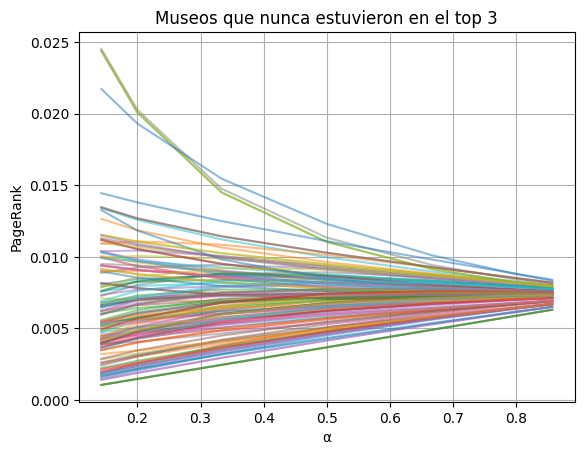

In [14]:
# museos fuera del top
todos_idx = set(df_alpha.index)
top3_idx = set(top_museos_alpha)
no_top3_idx = list(todos_idx - top3_idx)

df_no_top3 = df_alpha.loc[no_top3_idx].T
df_no_top3.index = alfa_vals
df_no_top3.sort_index(ascending=False, inplace=True)

ax = df_no_top3.plot(legend=False, alpha=0.5)
ax.set_title("Museos que nunca estuvieron en el top 3")
ax.set_xlabel("α")
ax.set_ylabel("PageRank")
ax.grid(True)
plt.show()

Aca graficamos los museos que no llegaron al top 3 en ninguna de las configuraciones. Observamos que estos nodos presentan valores de PageRank bajos y que sus curvas tienden a acercarse entre sí a medida que aumenta el parámetro α. Esto indica que, con mayor aleatoriedad (α alto), sus puntajes se igualan y se atenúan las pocas diferencias que tenían.

En cambio, con α bajo, algunos de estos museos alcanzan valores más altos de PageRank, lo cual puede deberse a que están mejor conectados localmente, recibiendo flujo desde museos relevantes cercanos. Sin embargo, esta ventaja relativa no es suficiente para que se ubiquen entre los nodos más importantes.

Este comportamiento resalta el rol de α como parámetro de control: regula el peso de la estructura topológica frente al componente aleatorio del modelo. Valores bajos amplifican las diferencias estructurales, mientras que valores altos suavizan el ranking, haciendo que todos los nodos poco conectados tiendan al mismo valor promedio. Así, α actúa como un “nivelador” de importancia cuando su valor se incrementa.

### 3b)

Para analizar cómo cambian las regiones más destacadas según el PageRank, se construyeron visualizaciones geográficas que representan cada museo con un tamaño proporcional a su valor de PageRank. Se probaron distintos valores de mmm (cantidad de vecinos más cercanos con los que se conecta cada museo) y α (probabilidad de reinicio aleatorio de la caminata).  
El siguiente código genera seis mapas comparativos, variando sistemáticamente los valores de los parámetros:

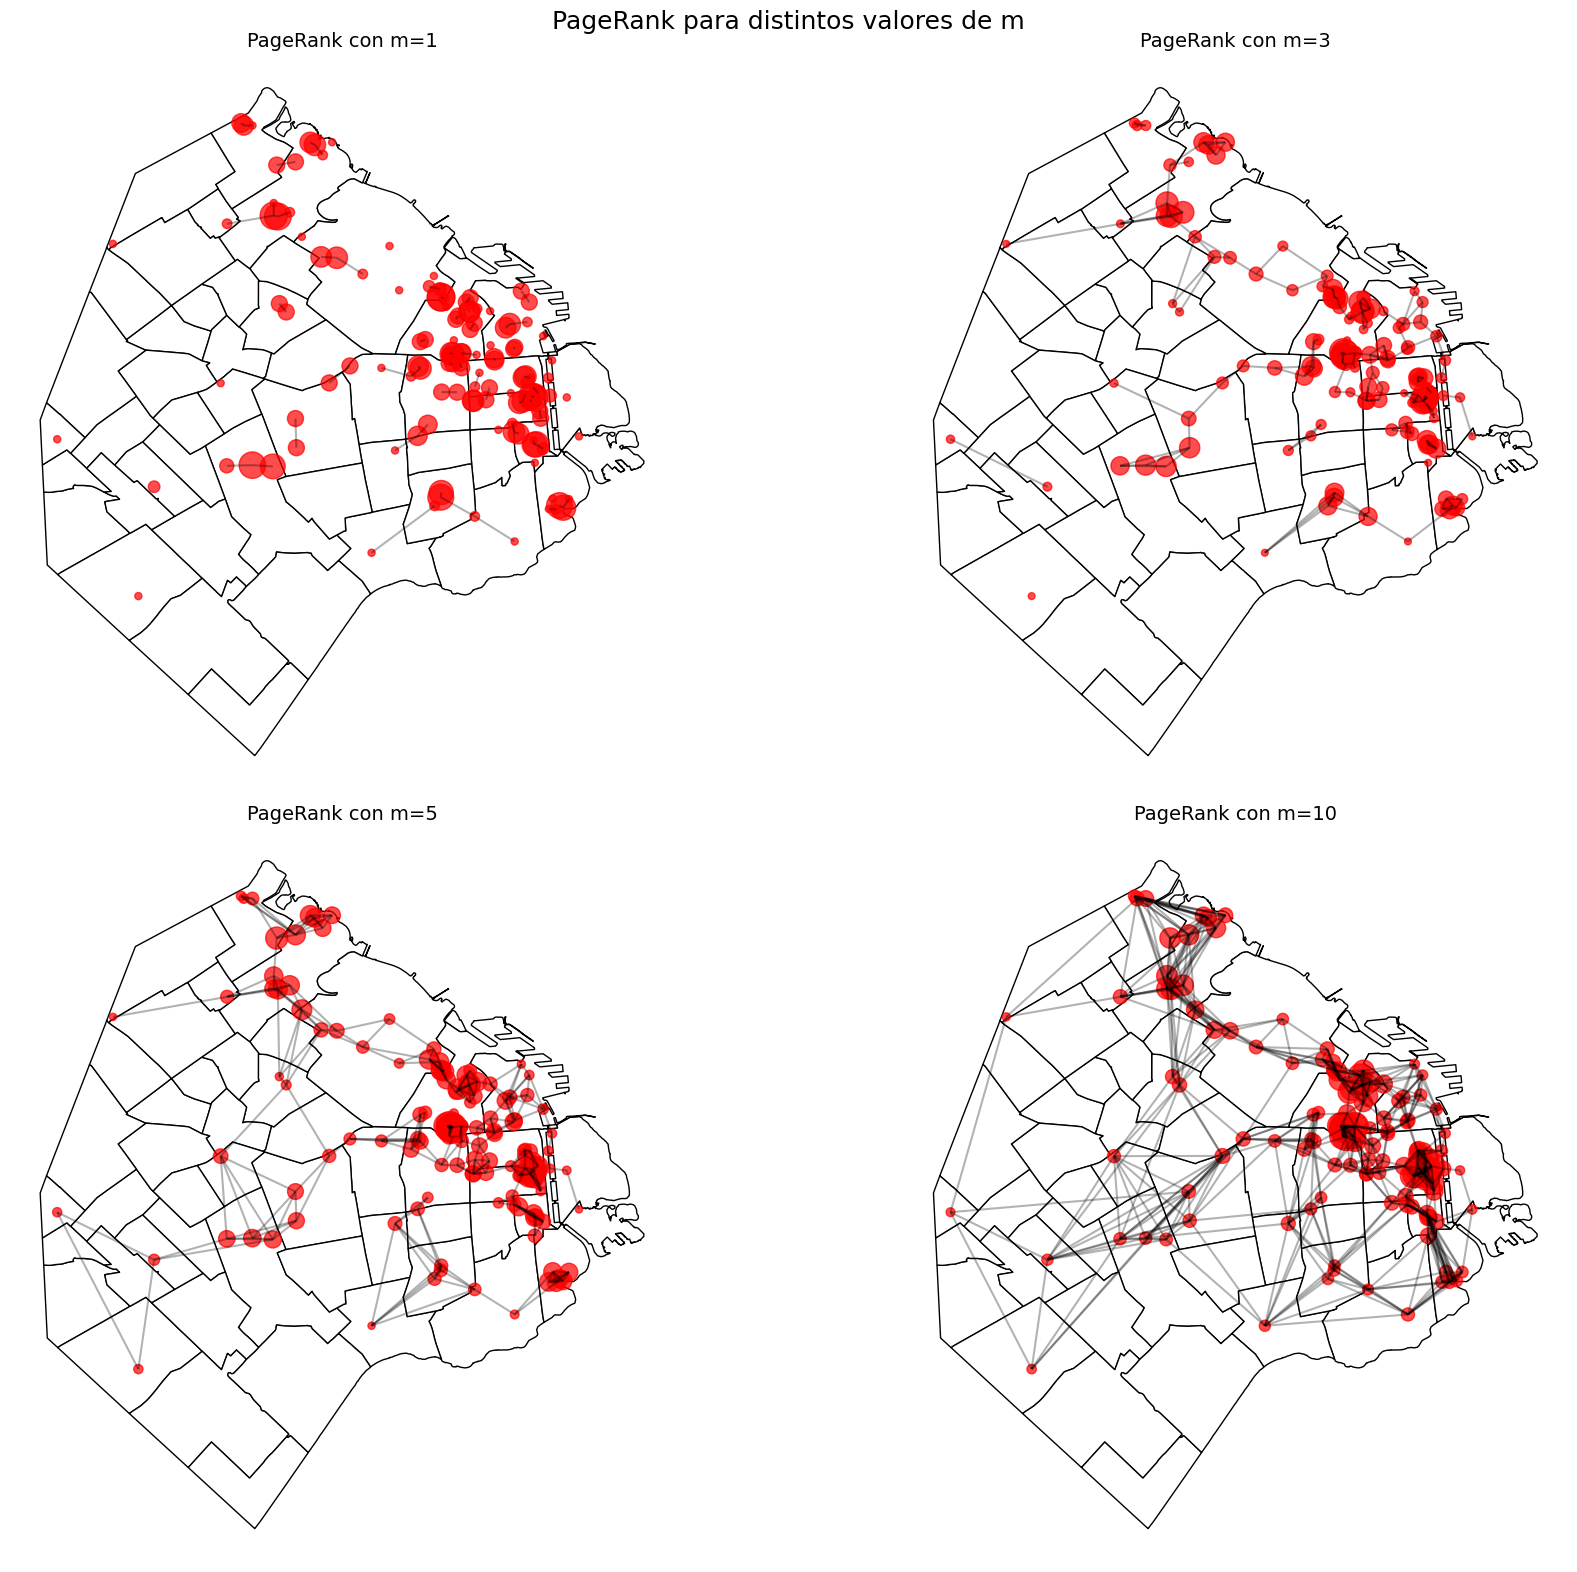

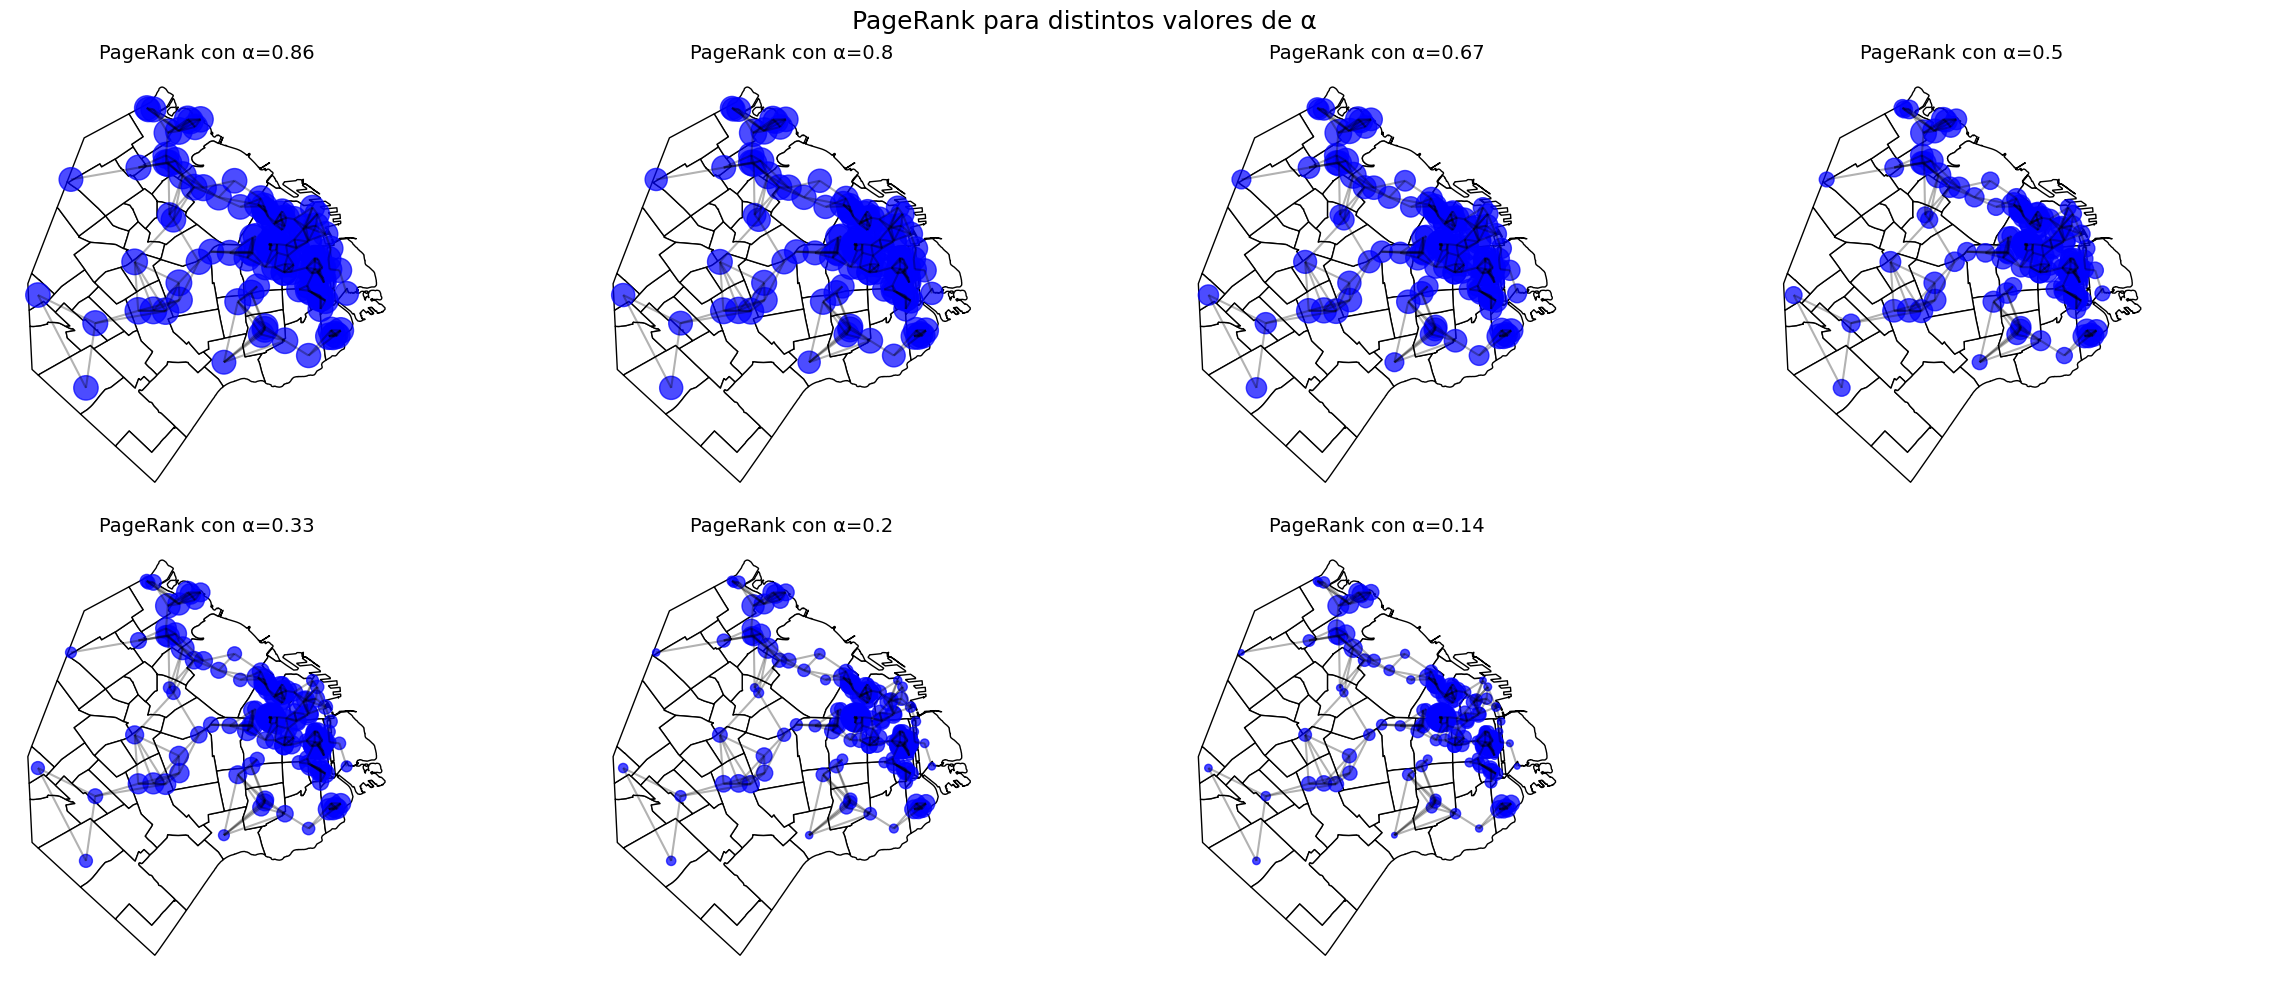

In [15]:
# Parámetros
alfa = 1/5  # fijamos alpha para comparar variaciones de m
m_vals = [1, 3, 5, 10]

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()

for i, m in enumerate(m_vals):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    p_norm = p / np.max(p)

    museos[f'pagerank_m{m}'] = p_norm
    
    # crear geodataframe de conexiones si las tenés disponibles, si no, saltealo
    edges = []
    for i1 in range(len(A)):
        for j1 in range(i1):
            if A[i1, j1] != 0:
                edges.append([museos.geometry.iloc[i1], museos.geometry.iloc[j1]])
    conexiones = gpd.GeoDataFrame(geometry=[LineString([p1, p2]) for p1, p2 in edges], crs=museos.crs)

    ax = axs[i]
    barrios.to_crs("EPSG:3857").plot(ax=ax, facecolor='white', edgecolor='black')
    conexiones.to_crs("EPSG:3857").plot(ax=ax, color='black', alpha=0.3)
    museos.to_crs("EPSG:3857").plot(ax=ax, 
                                    markersize=museos[f'pagerank_m{m}']*400,
                                    alpha=0.7,
                                    color='red')
    ax.set_title(f"PageRank con m={m}", fontsize=14)
    ax.axis('off')

plt.suptitle("PageRank para distintos valores de m", fontsize=18)
plt.tight_layout()
plt.show()

m = 5  # fijo para comparar variaciones de alfa
alfa_vals = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]

fig, axs = plt.subplots(2, 4, figsize=(24, 10))
axs = axs.flatten()

for i, alfa in enumerate(alfa_vals):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    p_norm = p / np.max(p)

    museos[f'pagerank_a{round(alfa, 2)}'] = p_norm

    edges = []
    for i1 in range(len(A)):
        for j1 in range(i1):
            if A[i1, j1] != 0:
                edges.append([museos.geometry.iloc[i1], museos.geometry.iloc[j1]])
    conexiones = gpd.GeoDataFrame(geometry=[LineString([p1, p2]) for p1, p2 in edges], crs=museos.crs)

    ax = axs[i]
    barrios.to_crs("EPSG:3857").plot(ax=ax, facecolor='white', edgecolor='black')
    conexiones.to_crs("EPSG:3857").plot(ax=ax, color='black', alpha=0.3)
    museos.to_crs("EPSG:3857").plot(ax=ax,
                                    markersize=museos[f'pagerank_a{round(alfa, 2)}']*400,
                                    alpha=0.7,
                                    color='blue')
    ax.set_title(f"PageRank con α={round(alfa, 2)}", fontsize=14)
    ax.axis('off')

# Ocultar subplots extras
for j in range(len(alfa_vals), len(axs)):
    axs[j].axis('off')

plt.suptitle("PageRank para distintos valores de α", fontsize=18)
plt.tight_layout()
plt.show()

A través de los mapas se pueden ver cómo cambian los resultados del modelo según los parámetros usados.

**Cambios con el parámetro m:**

Cuando m es chico (por ejemplo, m = 3), la red tiene menos conexiones, y algunos museos alejados pueden destacar porque tienen menos competencia.
Cuando m es más grande (como m = 6 o 10), hay más conexiones entre museos y se forman zonas más densas. En estos casos, los museos del centro o más conectados son los que más destacan. Algunos museos que antes tenían buenos valores de PageRank bajan porque ahora hay más opciones de conexión.

**Cambios con el parámetro $\alpha$:**  
Con valores de $\alpha$ más cercanos a 1 (por ejemplo, 6/7), el modelo salta al azar con mayor probabilidad, por lo que los valores de PageRank tienden a igualarse y se pierde la distinción entre nodos centrales y periféricos Con valores de $\alpha$ más cercanos a 0 (por ejemplo, 1/7), el salto aleatorio es poco frecuente, de modo que el PageRank se sustenta casi exclusivamente en las conexiones de la red 

## Punto 4:

En este punto, se busca estimar el vector $V$, cuya componente $V_i$ representa la cantidad de personas que iniciaron su recorrido en el museo $i$, a partir del vector $W$, donde cada componente $W_i$ indica la cantidad total de visitas que recibió el museo $i$. 
Se parte de la suposición de que cada persona realiza exactamente r visitas antes de abandonar la red de museos, y que su recorrido sigue la dinámica de una caminata aleatoria definida por la matriz de transición C.


### Justificación formal: ¿Por qué la distribución en el paso $k$ es $(C^k)\mathbf{v}$?

Supongamos que un visitante comienza en un museo con distribución inicial $\mathbf{v}$. En cada paso, el movimiento entre museos está determinado por la matriz $C$, que es de Markov. Entonces:

- Después de **1 paso**, la distribución esperada de visitas es $C\mathbf{v}$,  
- Después de **2 pasos**, es $C^2 \mathbf{v}$,
- Después de **$k$ pasos**, es $C^k \mathbf{v}$.

Esta relación se justifica por la definición recursiva de las *cadenas de Markov*: si $\mathbf{v}^{(k)}$ es la distribución en el paso $k$, se cumple que: $ \mathbf{v}^{(k)} = C \mathbf{v}^{(k-1)}$ y por lo tanto $\mathbf{v}^{(k)} = C^k \mathbf{v}$

### Total de visitas esperadas

Como cada persona hace $r$ visitas, y la distribución en cada paso $k$ es $(C^k)\mathbf{v}$, el **total esperado de visitas acumuladas** en cada museo se calcula sumando las distribuciones de los primeros $r$ pasos:

$$
w = v + Cv + C^2v + \cdots + C^{r-1}v = \left( \sum_{k=0}^{r-1} C^k \right) v = Bv, \quad \text{donde } B = \sum_{k=0}^{r-1} C^k
$$

De esta forma, el vector v puede calcularse como : $v = B^{-1}w$

### Interpretación
Esta formulación permite reconstruir la distribución de ingreso a la red de museos (es decir, desde qué museos ingresaron los visitantes) a partir del total acumulado de visitas $w$. Es especialmente útil cuando no se tiene acceso directo a la información de entrada pero sí se cuenta con la distribución total de visitas.  
El modelo también permite analizar cómo influye el número de pasos $r$:  
•	Si $r$ es pequeño, las visitas se concentran cerca del punto de entrada.  
•	Si $r$ es grande, la caminata se dispersa más y favorece a los museos con mayor conectividad.  

## Punto 5:

**Construccion de la función calcula_matriz_C_continua**  
Para construir la matriz de transición continua C, usamos la definición de la ecuación 4, que describe la probabilidad de transición de un museo i a otro museo j en función de la distancia entre ellos. Esta probabilidad está dada por:
(EQ 4)
La función se implementó de la siguiente manera:

In [16]:
def calcula_matriz_C_continua(D):
    D = D.copy()
    F = 1 / D
    np.fill_diagonal(F, 0)  # diagonal de ceros

    sumas = F.sum(axis=1) # Suma por filas
    Kinv = np.diag(np.where(sumas != 0, 1 / sumas, 0)) # Matriz diagonal con las inversas. Con np.where divide solo cuando sumas != 0.

    C = F.T @ Kinv

    return C

•	Primero se calcula la matriz $FFF$, que contiene los valores $f(dij)=1/dij$. Se pone 0 en la diagonal ya que no hay transiciones de un museo a sí mismo.  
•	Luego se suma cada fila de $FFF$ para obtener el denominador de la fórmula de transición.  
•	Se arma la matriz $K^{−1}$, que contiene en la diagonal la inversa de estas sumas.  
•	Finalmente, se calcula $C = (K^{−1})⋅F$, que normaliza cada fila para convertirla en una distribución de probabilidad, como requiere una matriz de transición.

**Construcción de la función calcula_B**    
En este punto buscamos construir la matriz $B$, que nos permitirá estimar cuántas personas ingresaron a la red de museos a través de cada nodo, es decir, calcular el vector v tal que $v=B^{−1}w$, donde w es el total de visitas registradas en cada museo y $r$ la cantidad de pasos que realiza cada visitante en la red.  
Para construir esta matriz, implementamos la **función calcula_B(C, cantidad_de_visitas)**, que sigue la lógica descrita.  
El código es el siguiente:

In [17]:
def calcula_B(C, cantidad_de_visitas):
    B = np.eye(C.shape[0])  # Inicia B como la matriz identidad (C^0)
    C_potencia = np.eye(C.shape[0])  # C^0 también

    for _ in range(cantidad_de_visitas - 1):  # Itera desde k = 1 hasta r - 1
        C_potencia = C_potencia @ C  # Calcula C^k
        B += C_potencia  # Suma C^k a B

    return B

La matriz B se inicializa como la identidad para representar el caso base $C^0=I$, y luego se van sumando las potencias sucesivas de $C$ hasta llegar a $C^{r−1}$.   Este enfoque nos permite obtener una matriz que captura la acumulación de visitas en toda la red a lo largo de r pasos de navegación.  
Con esta matriz calculada, estamos en condiciones de resolver la ecuación Bv=w para encontrar el vector $v$, que es justamente el objetivo del siguiente paso del ejercicio.  
Una vez construida la matriz B y con el vector w cargado, resolvemos la ecuación Bv=w para obtener el vector $v$, que nos dice cuántas personas comenzaron su recorrido en cada museo. Para eso, utilizamos la función calculaLU, que descompone B en dos matrices triangulares L y U, lo que permite resolver el sistema en dos pasos más simples.  
Primero, aplicamos la función de descomposición LU:  

In [18]:
r = 3
C_cont = calcula_matriz_C_continua(D)
B = calcula_B(C_cont, r)
L, U = calculaLU(B) 

C:\Users\fedob\AppData\Local\Temp\ipykernel_852\3856633762.py:3: RuntimeWarning: divide by zero encountered in divide
  F = 1 / D


Luego, resolvemos el sistema triangular inferior $Ly=w$, y con ese resultado, resolvemos el sistema superior Uv=y, usando solve_triangular de scipy: 

In [19]:
w = np.loadtxt("visitas.txt")  
y = scipy.linalg.solve_triangular(L, w, lower=True)  
v = scipy.linalg.solve_triangular(U, y)  

De esta forma, obtenemos el vector $v$, que representa la distribución estimada de entradas a la red de museos, considerando que cada visitante realizó $r$ = 3 visitas.  
Una vez obtenido el vector $v$, podemos estimar el total de personas que ingresaron a la red de museos calculando la norma 1 del vector, es decir, la suma de todas sus componentes. Esto representa el número total de visitantes que iniciaron su recorrido en algún museo.  
El cálculo se realiza con:  

In [20]:
def norma_1(vector):
    return np.sum(np.abs(vector))

total_visitantes = np.sum(v)
print("Total de visitantes:", norma_1(total_visitantes))

Total de visitantes: 136605.0


El resultado de esta operación nos da un valor aproximado de [136605.0] visitantes. Este número representa la cantidad total de personas que, a partir del modelo propuesto, se estima que comenzaron su recorrido en la red y realizaron hasta r = 3 visitas.  
Este resultado permite tener una estimación del flujo inicial de personas que entraron al sistema de museos, considerando que cada una realiza un máximo de tres visitas. Al modelar el comportamiento de los visitantes mediante una cadena de Markov con transiciones ponderadas por la distancia, logramos aproximar de forma razonable cómo se distribuye la atención del público entre los distintos museos. Esta información puede ser valiosa para entender patrones de movimiento, planificar recursos o mejorar la conectividad de ciertas instituciones dentro de la red.

#### Conclusion final:
A lo largo de este trabajo analizamos la red de museos de la ciudad utilizando conceptos de grafos, cadenas de Markov y el algoritmo de PageRank. A partir de una matriz de distancias geográficas, construimos distintas redes de conectividad en función del número de vecinos más cercanos (m) y del parámetro de aleatoriedad (α), observando cómo estas variaciones afectan la centralidad relativa de cada museo.  
Implementamos el cálculo del PageRank con una factorización LU personalizada, lo que nos permitió resolver sistemas lineales de forma eficiente y explorar los efectos del modelo desde una perspectiva computacional. Luego, mediante la matriz de transición continua y la estimación de visitantes según una cantidad fija de pasos en la red, logramos aproximar cuántas personas ingresaron inicialmente por cada museo.  
Este enfoque permitió identificar patrones relevantes, como la aparición de museos centrales que se mantienen estables frente a distintos parámetros, así como también casos donde la importancia de ciertas instituciones depende de la estructura de la red. Además, las visualizaciones geográficas aportaron una comprensión intuitiva del impacto de la conectividad en la visibilidad de cada nodo.  
En conjunto, el trabajo integró teoría, implementación y análisis exploratorio para ofrecer una mirada cuantitativa sobre el flujo de visitantes en un sistema cultural complejo, mostrando el valor que las herramientas para analizar datos que pueden aportar en contextos reales.

## Punto 6:

Para este ejercicio queremos estimar cómo se propaga un error del 5% en el vector w (total de visitas) a la estimación del vector v (primeras visitas), usando el número de condición 1 de la matriz $B$. Para esto, recordamos la siguiente desigualdad:  
**(EQ 6)**  
Primero seria ideal dejar en claro que el numero de condición de B es el siguiente:   
$cond1(B) = ∥B∥1⋅∥B−1∥1$  
Donde como ya sabemos, ambas normas de $B$ y su inversa son la suma máxima de sus columnas respectivamente.  
Antes de pasar al código, es relevante aclarar que el número de condición es una medida que refleja cuán sensible es la solución de un sistema lineal ante pequeños cambios en los datos de entrada. En este caso, nos indica cuánto puede amplificarse un error en el vector $w$ al calcular el vector $v$. Un número de condición cercano a 1 implica que el sistema es bien condicionado y el error no se amplifica significativamente. Por el contrario, un número de condición alto sugiere que el sistema es mal condicionado, y por lo tanto, pequeñas perturbaciones en los datos pueden generar grandes variaciones en los resultados.  
Con código, calculamos la cota superior de la siguiente manera:


In [21]:
from scipy.linalg import solve_triangular

def norma_inversa(B):
    N = B.shape[0]
    L, U = calculaLU(B)
    I = np.eye(N) # matriz identidad

    Y = solve_triangular(L, I, lower=True)

    B_inv = solve_triangular(U, Y)

    # Calculamos la norma 1 de la inversa
    return B_inv

norma_B = np.linalg.norm(B, ord=1)
norma_B_inv = np.linalg.norm(norma_inversa(B), ord=1)
cond_B = norma_B * norma_B_inv

# Asumiendo un error relativo del 5% en w como dice la consigna
error_relativo_w = 0.05
cota_error_relativo_v = cond_B * error_relativo_w

print("Número de condición en norma 1:", cond_B)
print("Cota para el error relativo en v:", cota_error_relativo_v)

Número de condición en norma 1: 5.051771176665004
Cota para el error relativo en v: 0.2525885588332502


Este cálculo nos permite estimar un límite superior para el error relativo en la estimación de v, es decir, una cota superior en la cantidad de visitantes que tuvo cada museo como punto de entrada.    
Al introducir un error del 5% en el vector $w$, nos interesaba estimar cuánto podía propagarse ese error hacia el vector $v$, que contiene la cantidad de personas que iniciaron su recorrido en cada museo. Para esto, utilizamos el número de condición 1 de la matriz $B$, construida a partir de la matriz de transición continua $C$ y el número de pasos r=3.  

El número de condición resultó ser (5.052417496873358). Este valor nos indica cuán sensible es el sistema a perturbaciones en los datos de entrada. En este caso, aplicando la fórmula de la ecuación 6. Y sabiendo que el error relativo en w es del 5% (0.05), obtuvimos que la superior para el error relativo en la estimación de v es (0.2526208748436679).   

Este resultado significa que, incluso un pequeño error en los datos de entrada puede amplificarse al resolver el sistema. Este ejercicio demuestra la importancia de considerar la estabilidad numérica en modelos de tránsito en redes. Al calcular el número de condición de la matriz $B$, pudimos estimar de forma precisa el impacto que un error de medición puede tener sobre las estimaciones finales. Esta herramienta permite evaluar la confiabilidad del modelo en contextos reales, donde los datos no son exactos, y reforzar el análisis de sensibilidad como parte del proceso de modelado.

## Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, '14'),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

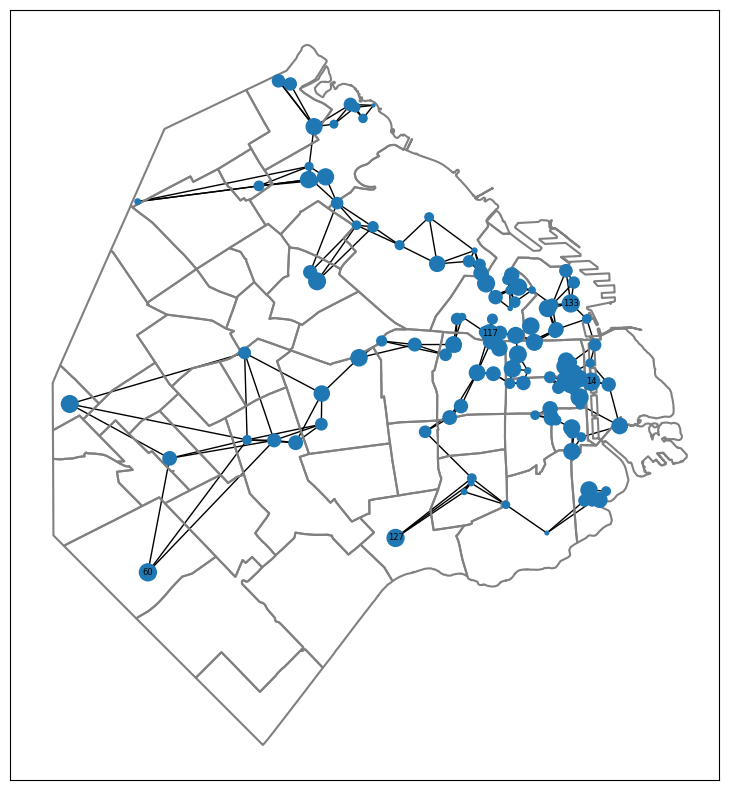

In [22]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres